# Fetching Data

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Kaggle API
api = KaggleApi()
api.authenticate()

dataset = "shivamkushwaha/bbc-full-text-document-classification"
download_path = "datasets/bbc-fulltext (document classification)"


os.makedirs(download_path, exist_ok=True)
api.dataset_download_files(dataset, path=download_path, unzip=True)

# Class Labels
class_labels = {'politics': 0, 'sport': 1, 'tech': 2, 'entertainment': 3, 'business': 4}
path = os.path.join(download_path, "bbc")
folders = os.listdir(path)

# lists to store the texts and labels
final_text = []
final_label = []

def read_extract_text_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            return file.read()

for label in folders:
    label_path = os.path.join(path, label)
    if label_path.endswith("README.TXT"):
        continue
    if label in class_labels:
        for text_file in os.listdir(label_path):
            file_path = os.path.join(label_path, text_file)
            text_content = read_extract_text_file(file_path)
            final_text.append(text_content)
            final_label.append(class_labels[label])

print('Total # of Text '+ str(len(final_text)))
print('Total # of Label '+ str(len(final_label)))

# The code for retrieving kaggle dataset was generated by CHATGPT

Dataset URL: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification
Total # of Text 2225
Total # of Label 2225


# 1.	Text Preprocessing: 

In [5]:
import pandas as pd

# create a dataframe for texts and labels
df = pd.DataFrame()
df['Text'] = final_text
df['Label'] = final_label

In [6]:
df.head()

,Text,Label
0,Musicians to tackle US red tape\n\nMusicians' ...,3
1,"U2's desire to be number one\n\nU2, who have w...",3
2,Rocker Doherty in on-stage fight\n\nRock singe...,3
3,Snicket tops US box office chart\n\nThe film a...,3
4,Ocean's Twelve raids box office\n\nOcean's Twe...,3


### (1) Tokenization and Count Vectorization with N-grams(options)
Tokenize the text using NLTK functions or regular expressions. Convert the text into a count vector representation either by using NLTK functions or by implementing it in code. (Please use random split, and the split ratio is 9:1)


In [8]:
# Before Tokenization, we have split the dataset to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.1, random_state=42)

In [9]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# defining a tokenizer with regular expression
tokenizer = RegexpTokenizer(r"[\w']+").tokenize

# creating countvectorizer with tokenizer parameters, and unigram and bigram
cv = CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2))

X_train_cv = cv.fit_transform(X_train) 
X_test_cv = cv.transform(X_test) 

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### (2) TF-IDF
Apply TF-IDF (Term Frequency-Inverse Document Frequency) to represent the document's terms based on their importance or use N-grams (e.g., unigrams, bigrams) to capture word sequences.


In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)

# 2.	Model Implementation

(1)	Use the classification models(Naïve Bayes, Logistic Regression (Lasso and Ridge), Decision Tree, Random Forest, Gradient Boosting) for training and prediction

In [14]:
from sklearn.naive_bayes import MultinomialNB 
NB_clf = MultinomialNB() # Declare the MultinomialNB classifier
NB_clf.fit(X_train_tfidf, y_train) #train the classifier 
print('Train set score: {:.3f}'.format(NB_clf.score(X_train_tfidf, y_train))) # accuracy for train 
print('Test set score: {:.3f}'.format(NB_clf.score(X_test_tfidf, y_test))) # accuracy for test 

Train set score: 0.986
Test set score: 0.901


In [15]:
from sklearn.linear_model import LogisticRegression

LR_clf = LogisticRegression() # declare classifier logistic regression
LR_clf.fit(X_train_tfidf, y_train) 
print('Train set score: {:.3f}'.format(LR_clf.score(X_train_tfidf, y_train))) 
print('Test set score: {:.3f}'.format(LR_clf.score(X_test_tfidf, y_test)))

Train set score: 0.998
Test set score: 0.964


In [16]:
from sklearn.linear_model import RidgeClassifier
import numpy as np
# before running ridge regression, we need to find the optimal parameters so we're spliting the dataset again
X_train_ridge, X_val_ridge, y_train_ridge, y_val_ridge = train_test_split(X_train_tfidf, y_train, 
                                                                          test_size=0.1, random_state=42)

max_score = 0
max_alpha = 0

for alpha in np.arange(0.1, 10, 0.1): # increment alpha by 0.1 from 0.1 to 10
    ridge_clf = RidgeClassifier(alpha=alpha) # declare a ridge classifier
    ridge_clf.fit(X_train_ridge, y_train_ridge)
    score = ridge_clf.score(X_val_ridge, y_val_ridge) # measure accuracy 
    if score > max_score: # max_score and max_alpha is changed when the new score is greater than the previous max_score
        max_score = score
        max_alpha = alpha
print('Max alpha {:.3f} at max validation score {:.3f}'.format(max_alpha, max_score))

Max alpha 0.100 at max validation score 0.980


In [17]:
ridge_clf = RidgeClassifier(alpha=0.1) #declare a ridge classifier
ridge_clf.fit(X_train_tfidf, y_train) #train
print('Train set score: {:.3f}'.format(ridge_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(ridge_clf.score(X_test_tfidf, y_test)))

Train set score: 1.000
Test set score: 0.982


In [18]:
X_train_lass, X_val_lass, y_train_lass, y_val_lass = train_test_split(X_train_tfidf, y_train, 
                                                                          test_size=0.1, random_state=42)

max_score = 0
max_c = 0

for c in np.arange(0.1, 10, 0.1): # increment c by 0.1 from 0.1 to 10
    lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    lasso_clf.fit(X_train_lass, y_train_lass)
    score = lasso_clf.score(X_val_lass, y_val_lass) # measure accuracy 
    if score > max_score: # max_score and max_c is changed when the new score is greater than the previous max_score
        max_score = score
        max_c = c
print('Max C {:.3f} at max validation score {:.3f}'.format(max_c, max_score))

Max C 8.200 at max validation score 0.960


In [19]:
lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=8.2) # same LogisticRegression but parameterized
lasso_clf.fit(X_train_tfidf, y_train) 
print('Train set score: {:.3f}'.format(lasso_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(lasso_clf.score(X_test_tfidf, y_test)))

Train set score: 0.999
Test set score: 0.964


In [20]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=48) # Decision Tree
tree.fit(X_train_tfidf, y_train)
print('Decision Tree train set score: {:.3f}'.format(tree.score(X_train_tfidf, y_train)))
print('Decision Tree test set score: {:.3f}'.format(tree.score(X_test_tfidf, y_test)))

Decision Tree train set score: 1.000
Decision Tree test set score: 0.848


In [21]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=48) # Random Forest
forest.fit(X_train_tfidf, y_train)
print('Random Forest train set score: {:.3f}'.format(forest.score(X_train_tfidf, y_train)))
print('Random Forest test set score: {:.3f}'.format(forest.score(X_test_tfidf, y_test)))

Random Forest train set score: 1.000
Random Forest test set score: 0.960


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train_tfidf, y_train)
print('Gradient Boosting train set score: {:.3f}'.format(gb.score(X_train_tfidf, y_train)))
print('Gradient Boosting test set score: {:.3f}'.format(gb.score(X_test_tfidf, y_test)))

Gradient Boosting train set score: 1.000
Gradient Boosting test set score: 0.955


# 3.	Performance Evaluation

### (1)	Perform at least five combinations of preprocessing techniques and classification models
### (2)	Analyze the the train and test accuracy / precision / recall / F1-score of each combination. 


#### 1. Stop words + logistic regression

In [26]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score

# defining a tokenizer with regular expression
tokenizers = RegexpTokenizer(r"[\w']+").tokenize

# creating countvectorizer with tokenizer parameters, unigram and bigram, and english stopwords
cvs = CountVectorizer(tokenizer=tokenizers, ngram_range=(1, 2), stop_words = stopwords.words('english'))

X_train_cv = cvs.fit_transform(X_train) 
X_test_cv = cvs.transform(X_test) 

from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)

# LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train_tfidf, y_train)

# accuracy
print('Train set score: {:.3f}'.format(logistic.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(logistic.score(X_test_tfidf, y_test)))
y_pred_logistic = logistic.predict(X_test_tfidf)

# precision, recall, f1-score
precision = precision_score(y_test, y_pred_logistic, average='weighted')
recall = recall_score(y_test, y_pred_logistic, average='weighted')
f1 = f1_score(y_test, y_pred_logistic, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train set score: 0.999
Test set score: 0.987
Precision: 0.9868649626733177
Recall: 0.9865470852017937
F1 Score: 0.9865025060475053


#### 2. tokenizer with at least 4 characters + stopwords + lemmatization + ridge regression

In [28]:
from nltk.stem import WordNetLemmatizer

RegTok = RegexpTokenizer("[\w']{4,}") # tokenizer with regular expressions + at least 4 characters
english_stops = set(stopwords.words('english')) #Set up English stopwords

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # exclude using stopwords
    words = [word for word in tokens if (word not in english_stops)]
    # apply Lemmatizer
    features = list(map(lambda token: WordNetLemmatizer().lemmatize(token), words))
    return features

# creating countvectorizer with tokenizer parameters, unigram and bigram, and english stopwords
cv = CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), stop_words = stopwords.words('english'))

X_train_cv = cv.fit_transform(X_train) 
X_test_cv = cv.transform(X_test) 

from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)


X_train_ridge, X_val_ridge, y_train_ridge, y_val_ridge = train_test_split(X_train_tfidf, y_train, 
                                                                          test_size=0.1, random_state=42)

max_score = 0
max_alpha = 0

for alpha in np.arange(0.1, 10, 0.1): # increment alpha by 0.1 from 0.1 to 10
    ridge_clf = RidgeClassifier(alpha=alpha) # declare a ridge classifier
    ridge_clf.fit(X_train_ridge, y_train_ridge)
    score = ridge_clf.score(X_val_ridge, y_val_ridge) # measure accuracy 
    if score > max_score: # max_score and max_alpha is changed when the new score is greater than the previous max_score
        max_score = score
        max_alpha = alpha
print('Max alpha {:.3f} at max validation score {:.3f}'.format(max_alpha, max_score))

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Max alpha 0.100 at max validation score 0.990


In [29]:
ridge_clf = RidgeClassifier(alpha=0.1) #declare a ridge classifier
ridge_clf.fit(X_train_tfidf, y_train) #train

# accuracy
print('Train set score: {:.3f}'.format(ridge_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(ridge_clf.score(X_test_tfidf, y_test)))

# predictions
y_pred = ridge_clf.predict(X_test_tfidf)


# precision, recall, f1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Train set score: 1.000
Test set score: 0.982
Precision: 0.9826439064107225
Recall: 0.9820627802690582
F1 Score: 0.9820864717158728


#### 3. stopwords + port stemmer + MultinomialNB

In [31]:
from nltk.stem.porter import PorterStemmer

RegTok = RegexpTokenizer("[\w']+") # tokenizer with regular expressions + at least 4 characters
english_stops = set(stopwords.words('english')) #Set up English stopwords

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # exclude using stopwords
    words = [word for word in tokens if (word not in english_stops)]
    # apply PorterStemmer
    features = (list(map(lambda token: PorterStemmer().stem(token),words)))
    return features

# creating countvectorizer with tokenizer parameters, unigram and bigram, and english stopwords
cv = CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), stop_words = stopwords.words('english'))

X_train_cv = cv.fit_transform(X_train) 
X_test_cv = cv.transform(X_test) 

from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()
X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)

# MultinomialNB
NB = MultinomialNB()
NB.fit(X_train_tfidf, y_train)

# print accuracy
print('Train set score: {:.3f}'.format(NB.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(NB.score(X_test_tfidf, y_test)))
y_pred = NB.predict(X_test_tfidf)

# precision, recall, f1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train set score: 0.997
Test set score: 0.969
Precision: 0.9698839521087435
Recall: 0.968609865470852
F1 Score: 0.9679755085838142


#### 4. stopwords + ngram (1,3) + lasso regression

In [33]:
# defining a tokenizer with regular expression
tokenizer = RegexpTokenizer(r"[\w']+").tokenize

# creating countvectorizer with tokenizer parameters, unigram and bigram, and english stopwords
cv = CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 3), stop_words = stopwords.words('english'))

X_train_cv = cv.fit_transform(X_train) 
X_test_cv = cv.transform(X_test) 

from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)


X_train_lass, X_val_lass, y_train_lass, y_val_lass = train_test_split(X_train_tfidf, y_train, 
                                                                          test_size=0.1, random_state=42)

max_score = 0
max_c = 0

for c in np.arange(0.1, 10, 0.1): # increment c by 0.1 from 0.1 to 10
    lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    lasso_clf.fit(X_train_lass, y_train_lass)
    score = lasso_clf.score(X_val_lass, y_val_lass) # measure accuracy 
    if score > max_score: # max_score and max_c is changed when the new score is greater than the previous max_score
        max_score = score
        max_c = c
print('Max C {:.3f} at max validation score {:.3f}'.format(max_c, max_score))

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Max C 8.000 at max validation score 0.970


In [34]:
lasso_clf = LogisticRegression(penalty='l1', solver='liblinear', C=8) # same LogisticRegression but parameterized
lasso_clf.fit(X_train_tfidf, y_train) 
print('Train set score: {:.3f}'.format(lasso_clf.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(lasso_clf.score(X_test_tfidf, y_test)))

y_pred = lasso_clf.predict(X_test_tfidf)

# precision, recall, f1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Train set score: 0.998
Test set score: 0.964
Precision: 0.9653449767917552
Recall: 0.9641255605381166
F1 Score: 0.9641598137572046


#### 5. tokenizer with at least 4 characters + stopwords + lemmatization + GradientBoosting  

In [36]:
from nltk.stem import WordNetLemmatizer

RegTok = RegexpTokenizer("[\w']{4,}") # tokenizer with regular expressions + at least 4 characters
english_stops = set(stopwords.words('english')) #Set up English stopwords

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower())
    # exclude using stopwords
    words = [word for word in tokens if (word not in english_stops)]
    # apply Lemmatizer
    features = list(map(lambda token: WordNetLemmatizer().lemmatize(token), words))
    return features

# creating countvectorizer with tokenizer parameters, unigram and bigram, and english stopwords
cv = CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2), stop_words = stopwords.words('english'))

X_train_cv = cv.fit_transform(X_train) 
X_test_cv = cv.transform(X_test) 

from sklearn.feature_extraction.text import TfidfTransformer

# define tfidftransformer
transformer = TfidfTransformer()

X_train_tfidf = transformer.fit_transform(X_train_cv)
X_test_tfidf = transformer.fit_transform(X_test_cv)


# GradientBoostingClassifier
Gradient = GradientBoostingClassifier()
Gradient.fit(X_train_tfidf, y_train)

# print accuracy
print('Train set score: {:.3f}'.format(Gradient.score(X_train_tfidf, y_train)))
print('Test set score: {:.3f}'.format(Gradient.score(X_test_tfidf, y_test)))
y_pred = Gradient.predict(X_test_tfidf)

# precision, recall, f1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train set score: 1.000
Test set score: 0.946
Precision: 0.9477874137340715
Recall: 0.9461883408071748
F1 Score: 0.9464381326963648


### Analysis

The first Logistic regression model using both unigrams and bigrams without English stop words achieved the highest test score, precision, recall, and f1-score.

Train set score: 0.999

Test set score: 0.987

Precision: 0.9868649626733177

Recall: 0.9865470852017937

F1 Score: 0.9865025060475053

Overall, logistic regression models (both Lasso and Ridge) performed better than other algorithms. Removing English stop words and using up to bigrams helped improve accuracy, but stemming and setting specific character lengths didn't have much of an impact.

# 4. Word Cloud Visualization:

### (1)	Select one of the result, and then generate Word Clouds to visualize the key words for each category.

#### Word Cloud using Logistic Regression results

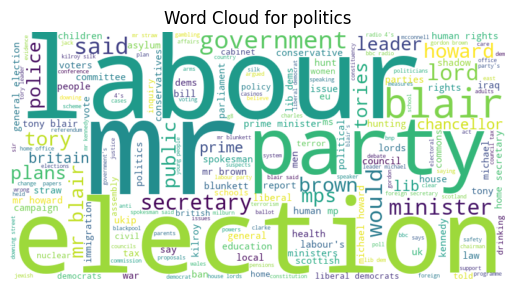

In [41]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# plot word cloud from coefficients
def plot_coeff_wordcloud(coefs, title):
    
    # generate_from_frequencies() method generates the word cloud from a dictionary
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(coefs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {title}")
    plt.axis('off')
    plt.show()

# feature names from CountVectorizer
feature_names = cvs.get_feature_names_out()

# coefficients from Logistic Regression model
coefs = logistic.coef_

# create a dictionary of feature names and coefficients for class 0 which is politics
coef_dict = {feature_names[j]: coefs[0, j] for j in range(len(feature_names))}

# sorting it by coefficients (largest coefficients first)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: item[1], reverse=True))

plot_coeff_wordcloud(sorted_coef_dict, 'politics')

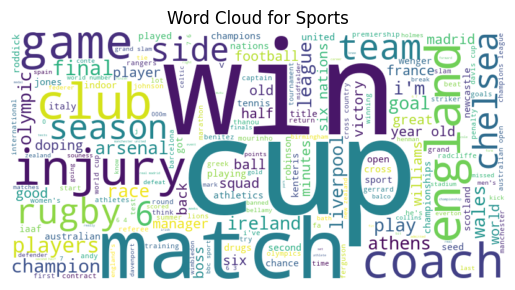

In [42]:
# create a dictionary of feature names and coefficients for class 1 which is sports
coef_dict = {feature_names[j]: coefs[1, j] for j in range(len(feature_names))}

# sorting it by coefficients (largest coefficients first)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: (item[1]), reverse=True))

plot_coeff_wordcloud(sorted_coef_dict, 'Sports')

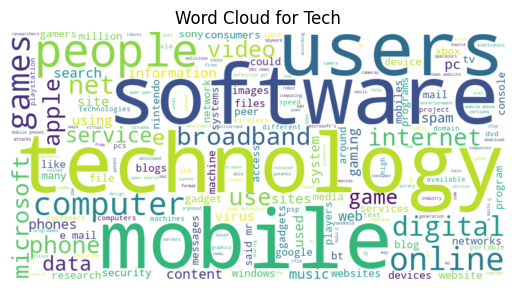

In [43]:
# create a dictionary of feature names and coefficients for class 2 which is tech
coef_dict = {feature_names[j]: coefs[2, j] for j in range(len(feature_names))}

# sorting it by coefficients (largest coefficients first)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: (item[1]), reverse=True))

plot_coeff_wordcloud(sorted_coef_dict, 'Tech')

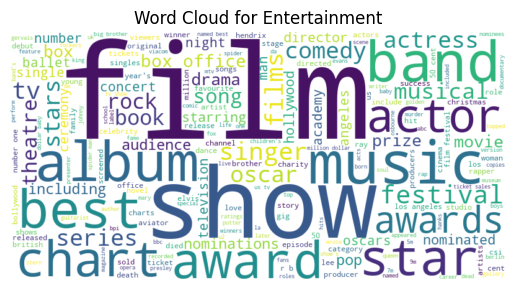

In [44]:
# create a dictionary of feature names and coefficients for class 3 which is entertainment
coef_dict = {feature_names[j]: coefs[3, j] for j in range(len(feature_names))}

# sorting it by coefficients (largest coefficients first)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: (item[1]), reverse=True))

plot_coeff_wordcloud(sorted_coef_dict, 'Entertainment')

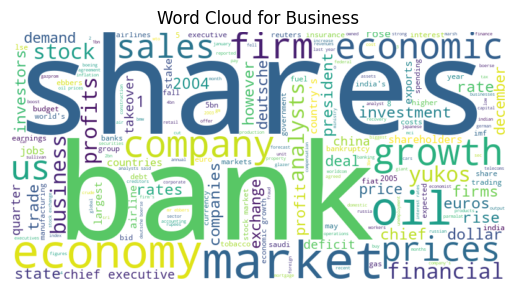

In [45]:
# create a dictionary of feature names and coefficients for class 4 which is business
coef_dict = {feature_names[j]: coefs[4, j] for j in range(len(feature_names))}

# sorting it by coefficients (largest coefficients first)
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda item: (item[1]), reverse=True))

plot_coeff_wordcloud(sorted_coef_dict, 'Business')

The report should be submitted in a free format that includes both the code and the model analysis.